
# <p style="background-color:#9F2D45;color:white;font-size:110%;text-align:center;border-radius:10px 10px;height:70px;padding-top: 20px;">‚öôÔ∏èPredictive Maintenance using Acoustic Emissions</p>
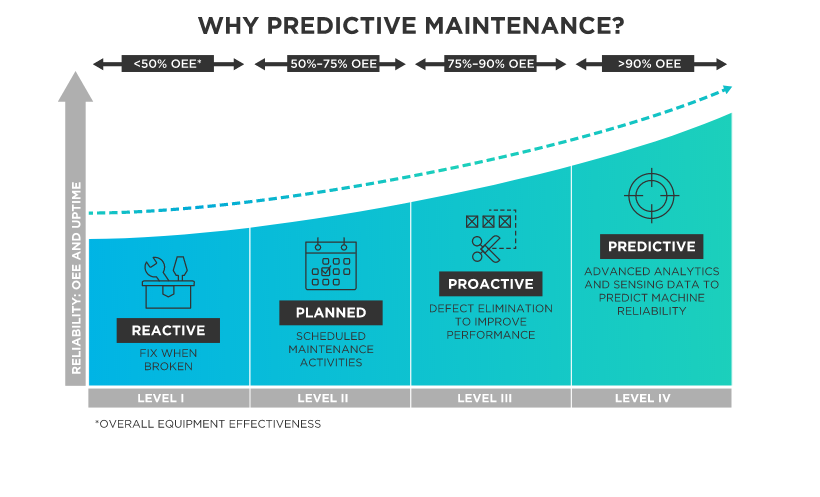

### About the project

This project was carried out under the supervision of a doctoral student in mechanics, a teacher researcher in mechanics and by a student in the field of data sciences (myself) of the University of Technology of Compi√®gne (UTC) with the aim of studying the various existing tracks for predictive maintenance and their way of development.

### About predictive maintenance

In order to retain customers, increase profits and lower production costs, it is essential for it is essential for a company to be competitive on the market and to optimize and to optimize its maintenance process. Having a reliable production line with automated maintenance allows to change parts at the right time to avoid breakdowns and possible malfunctions.

When we talk about quality management system, the *ISO 1900 standard* is essential. Planning maintenance allows to respect the requirements of this system of this system and to gain the confidence of its suppliers and customers. It is a a recognized guarantee of quality that allows industries to be more efficient in their their organization. By anticipating maintenance, you increase customer satisfaction because stock and production shortages are avoided. In addition, you increase your internal efficiency by reducing repair costs, by increasing the life span of the infrastructure and the working conditions.

On the surface, the maintenance categories all look interchangeable, but there are nuanced differences between reactive, preventive, proactive, and predictive maintenance.

- **Reactive**: Reactive maintenance is exactly what it sounds like. Equipment goes down or malfunctions and needs immediate repair. Most safety and equipment teams understand that being overly reliant on a singularly reactive maintenance strategy is costly and potentially dangerous. How you respond to those issues is a bigger part of your planned maintenance strategies. Put another way, when you plan for problems ahead of time, the less likely you are to have many stack up and shut down production.


- **Preventive**: Preventive maintenance includes a regular, scheduled program for each piece of equipment in your system. It‚Äôs usually scheduled at different intervals and can be labor intensive. Equipment manufacturers usually include a recommended preventive maintenance schedule. Preventive maintenance is almost always more cost-effective than reactive maintenance because it can prolong the life of parts and equipment. While preventive maintenance manages and reduces risk, data and measurement today can lead to even more cost-effective programs.


- **Predictive**: Preventive and predictive maintenance sound interchangeable, but there is a nuanced difference. Preventive maintenance is executed at specified intervals, while predictive maintenance uses data and performance metrics from the equipment itself. By looking for algorithmic trends, your team and partners will get a better idea of what failures could be lurking, and what parts and issues can actually be left alone. Indicators like temperature, pressure, vibration, and other data points indicate issues that should be addressed immediately. Scheduled (or preventive) maintenance relies on a series of assumptions about equipment. Predictive maintenance could be more cost effective, without scheduled down-time and repair work that may in fact not be necessary.


- **Proactive**: A proactive strategy combines predictive and preventive approaches by leveraging baseline performance numbers, monitoring equipment over time, and establishing a strategy to maintain equipment only when it‚Äôs needed. A proactive maintenance strategy goes beyond an established schedule. It addresses the common root issues of failure, to give you a holistic and comprehensive plan that addresses issues before they happen. Most organizations face big challenges when deciding how to allocate resources toward a maintenance program. Comparing and analyzing data from both new and aging equipment highlights likely failures. A proactive analysis and scheduled inspections put you in control of your maintenance in an intelligent way that also decreases cost over time. Working with a qualified safety expert further ensures that your equipment is satisfying safety requirements for your insurance carriers and approvals from various safety agencies.

### Aim of the project
Here the goal is to design a predictive maintenance system by predicting the occurrence of defects in motors using the noise emitted by the motors to determine the type of problem. There are 3 types of defects:

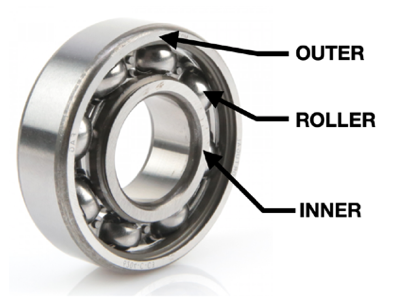

When the engine rotates, the sounds is different and so if we record the sound emitted by the engine, we can predict whether or not the engine is broken and what kind of problem there is.

During this project, I will study three different  to answer the initial problem: one using CNN, an other one using feature extraction and a combinaison of both solutions.

### About the data

The data consists in 4 audios of 12 seconds each of the different engines.

----

# <p style="background-color:#C2586E;color:white;font-size:100%;text-align:center;border-radius:10px 10px;">1. Imports</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
from scipy import io, misc
import scipy
import tensorflow as tf
import glob
from PIL import Image
import os
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from keras.preprocessing.image import ImageDataGenerator
import random
import keras.backend as K
import keras
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

---

# <p style="background-color:#C2586E;color:white;font-size:100%;text-align:center;border-radius:10px 10px;">2. Load the data</p>

### Parameters

Every sample will be 0.2 seconds long and is recorded at a 10000Hz frequency.

In [2]:
duration_samples = 0.2 #seconds
size_max = 120000
frequence = 10000 #Hertz

### Loading

In [3]:
file = "../input/engine-acoustic-emissions/dataset.mat"

dataset = scipy.io.loadmat(file)

df_normal = dataset["normal"].reshape(-1)[:size_max]
df_inner = dataset["inner"].reshape(-1)[:size_max]
df_roller = dataset["roller"].reshape(-1)[:size_max]
df_outer = dataset["outer"].reshape(-1)[:size_max]

data = [df_normal,df_inner,df_roller,df_outer]

In [4]:
def load_data(train=0.7):
    type_track = 0
    n_samples_each = int(size_max/frequence/duration_samples)
    audios_train = []
    audios_test = []
    number_train=int(n_samples_each*0.7)

    for track in data:
        for i in range(0,n_samples_each):
            t1 = int(i*frequence*duration_samples)
            t2 = int((i+1)*frequence*duration_samples)
            new = list(track)[t1:t2]
            if i<number_train:
                audios_train.append((type_track,new))
            else:
                audios_test.append((type_track,new))
        type_track = type_track+1
    np.random.seed(1)
    np.random.shuffle(audios_train)
    np.random.seed(1)
    np.random.shuffle(audios_test)
    return [i[1] for i in audios_train], [i[1] for i in audios_test], [i[0] for i in audios_train], [i[0] for i in audios_test]

In [5]:
audios_train, audios_test, label_train, label_test = load_data()

### The audios

In [6]:
IPython.display.Audio(df_normal, rate=frequence)

In [7]:
IPython.display.Audio(df_inner, rate=frequence)

In [8]:
IPython.display.Audio(df_roller, rate=frequence)

In [9]:
IPython.display.Audio(df_outer, rate=frequence)

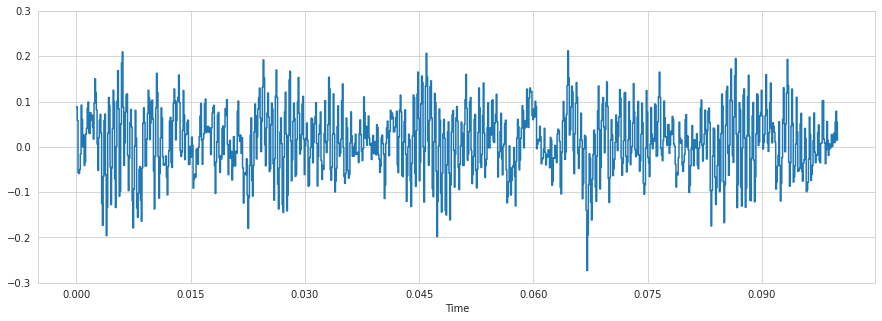

In [10]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_normal[:1000], sr=frequence)
plt.show()

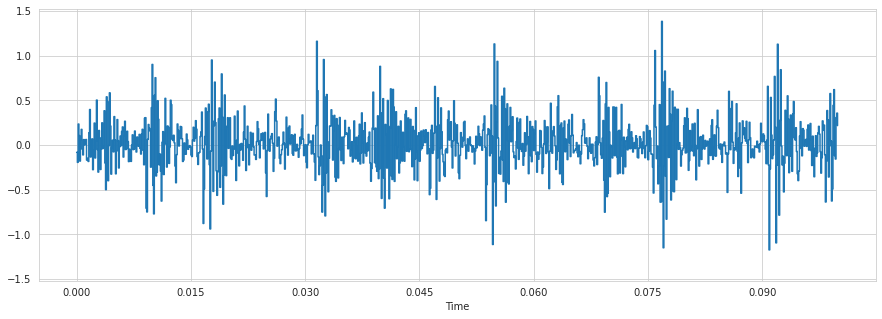

In [11]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_inner[:1000], sr=frequence)
plt.show()

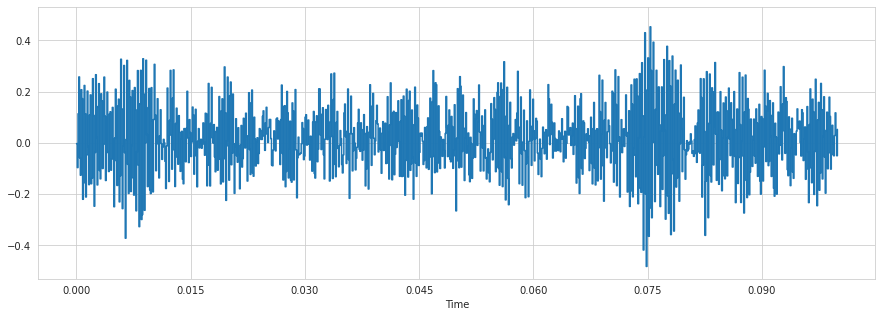

In [12]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_roller[:1000], sr=frequence)
plt.show()

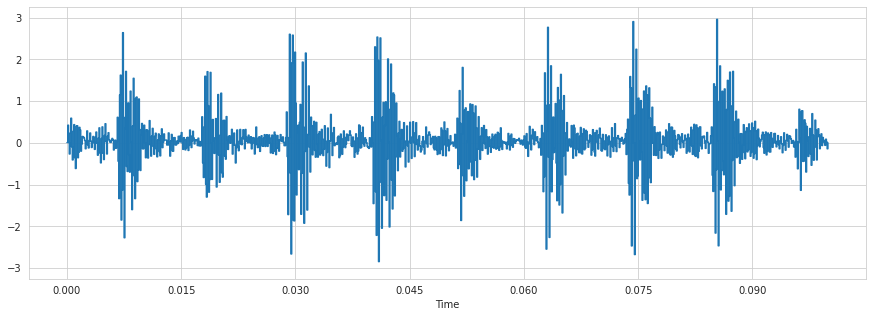

In [13]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_outer[:1000], sr=frequence)
plt.show()

> üìå Now we have for the traning and test data a list of arrays giving the sound for the period of the sample.

-----------

# <p style="background-color:#C2586E;color:white;font-size:100%;text-align:center;border-radius:10px 10px;">3. CNN Approach</p>

To use this method, I will first generate an image representation of every sounds. For that I will use different type of graph representations such as amplitude graphs, spectral contrasts graphs, chroma graphs, etc.

Those different graphs are created using different maths techniques wavelet transforms for example.

In [14]:
def processing_images(audios_train,audios_test):
    mels_train = []
    for audio in audios_train:
        n_fft = 2048 # window size
        hop_length = 512 # window hop length for STFT

        fig, ax = plt.subplots(figsize=(3, 2))
        stft = librosa.stft(np.asarray(audio), n_fft=n_fft, hop_length=hop_length)
        lplt.specshow(stft, sr=frequence, x_axis='time', y_axis='hz');
        plt.axis('off');
        fig.canvas.draw()
        data1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data1 = data1.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        stft_db = librosa.amplitude_to_db(stft, ref=np.max)
        lplt.specshow(stft_db, sr=frequence, x_axis='time', y_axis='hz', cmap='cool');
        plt.axis('off');
        fig.canvas.draw()
        data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data2 = data2.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        S,phase = librosa.magphase(librosa.stft(np.asarray(audio)))
        spectral = librosa.feature.spectral_contrast(S=S,sr=frequence,fmin=30)
        lplt.specshow(spectral, sr=frequence, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool');
        plt.axis('off');
        fig.canvas.draw()
        data3 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data3 = data3.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        chroma = librosa.feature.chroma_stft(np.asarray(audio), sr=frequence)
        lplt.specshow(chroma, sr=frequence, x_axis='time', y_axis='chroma', cmap='coolwarm');
        plt.axis('off');
        fig.canvas.draw()
        data4 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data4 = data4.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=frequence, n_mfcc=20)
        lplt.specshow(mfccs, x_axis='time');
        plt.axis('off');
        fig.canvas.draw()
        data5 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data5 = data5.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        mels_train.append(np.concatenate((data1,data2,data3,data4,data5),axis=0).reshape(720, 216, 3))

    mels_test = []
    for audio in audios_test:
        n_fft = 2048 # window size
        hop_length = 512 # window hop length for STFT

        fig, ax = plt.subplots(figsize=(3, 2))
        stft = librosa.stft(np.asarray(audio), n_fft=n_fft, hop_length=hop_length)
        lplt.specshow(stft, sr=frequence, x_axis='time', y_axis='hz');
        plt.axis('off');
        fig.canvas.draw()
        data1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data1 = data1.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        stft_db = librosa.amplitude_to_db(stft, ref=np.max)
        lplt.specshow(stft_db, sr=frequence, x_axis='time', y_axis='hz', cmap='cool');
        plt.axis('off');
        fig.canvas.draw()
        data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data2 = data2.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        S,phase = librosa.magphase(librosa.stft(np.asarray(audio)))
        spectral = librosa.feature.spectral_contrast(S=S,sr=frequence,fmin=30)
        lplt.specshow(spectral, sr=frequence, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool');
        plt.axis('off');
        fig.canvas.draw()
        data3 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data3 = data3.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        chroma = librosa.feature.chroma_stft(np.asarray(audio), sr=frequence)
        lplt.specshow(chroma, sr=frequence, x_axis='time', y_axis='chroma', cmap='coolwarm');
        plt.axis('off');
        fig.canvas.draw()
        data4 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data4 = data4.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        fig, ax = plt.subplots(figsize=(3, 2))
        mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=frequence, n_mfcc=20)
        lplt.specshow(mfccs, x_axis='time');
        plt.axis('off');
        fig.canvas.draw()
        data5 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data5 = data5.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        mels_test.append(np.concatenate((data1,data2,data3,data4,data5),axis=0).reshape(720, 216, 3))
        
    return mels_train, mels_test

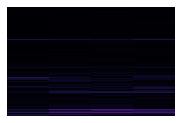

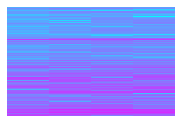

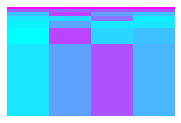

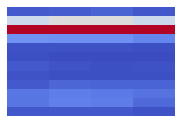

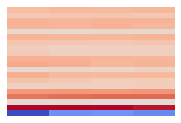

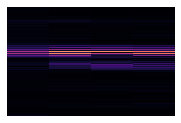

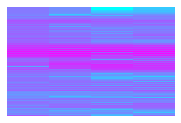

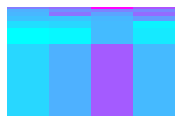

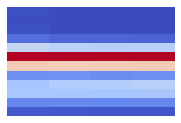

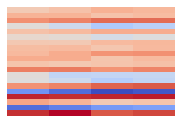

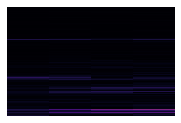

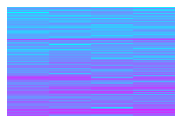

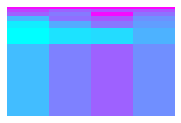

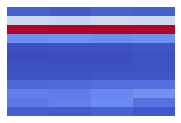

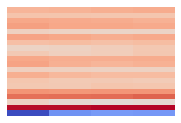

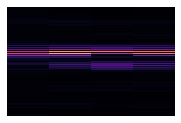

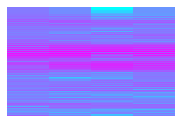

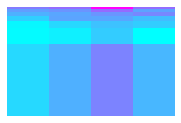

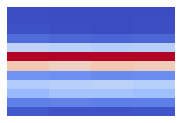

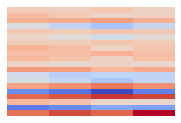

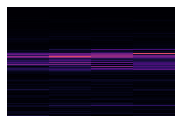

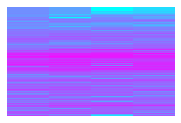

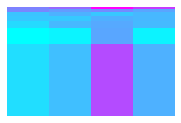

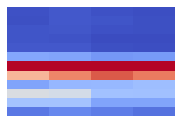

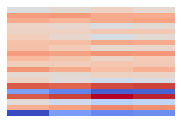

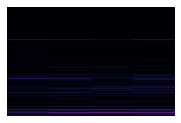

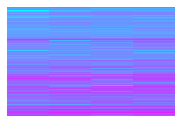

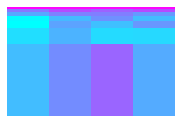

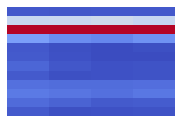

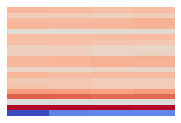

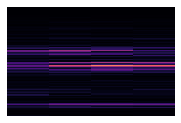

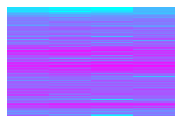

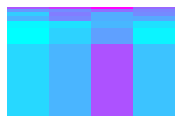

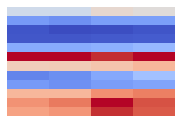

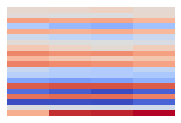

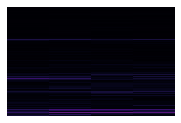

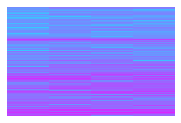

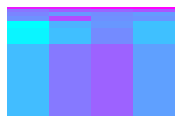

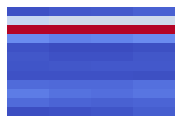

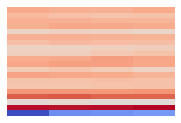

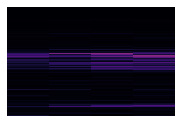

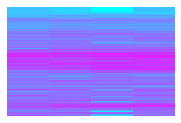

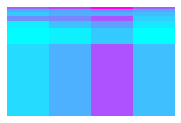

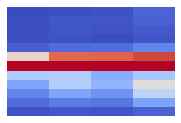

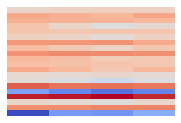

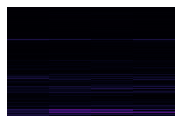

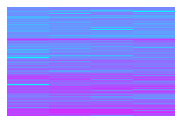

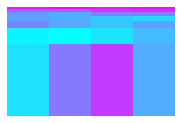

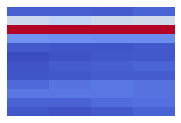

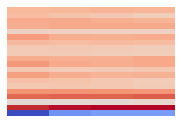

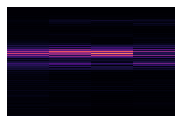

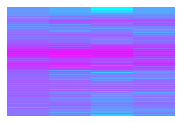

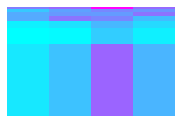

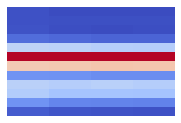

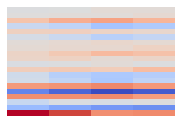

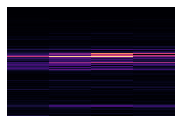

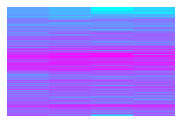

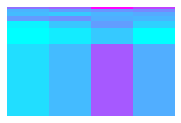

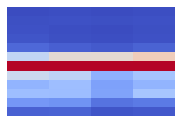

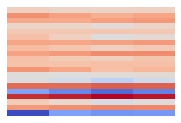

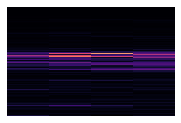

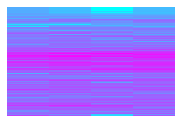

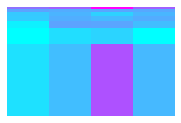

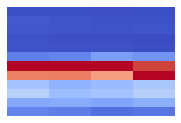

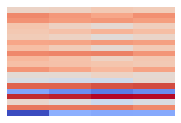

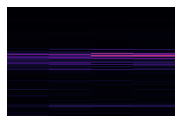

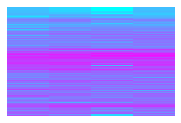

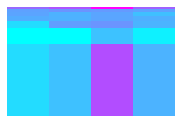

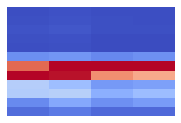

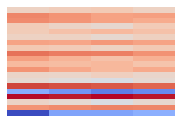

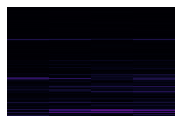

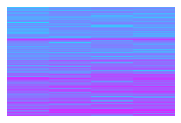

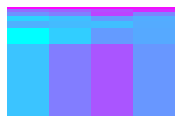

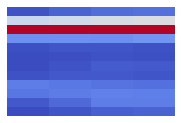

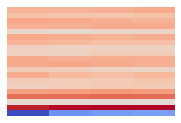

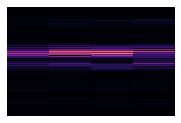

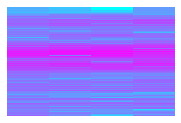

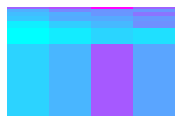

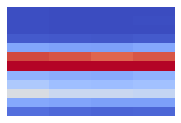

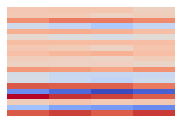

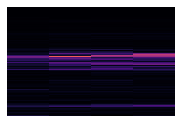

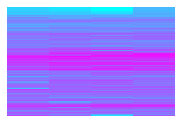

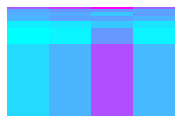

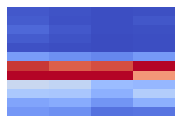

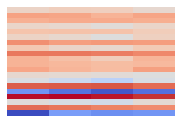

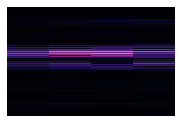

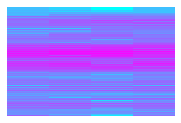

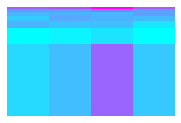

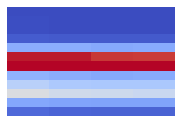

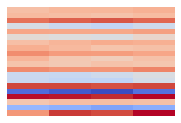

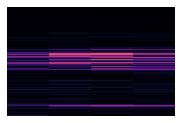

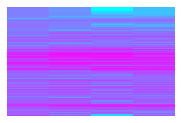

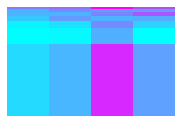

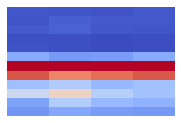

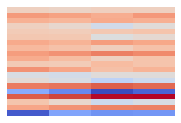

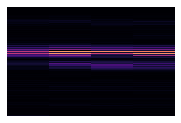

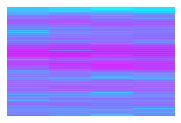

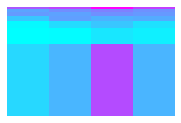

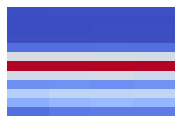

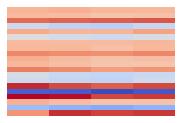

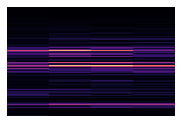

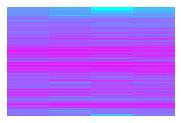

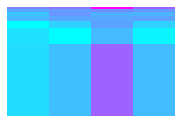

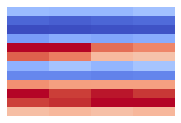

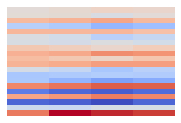

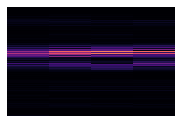

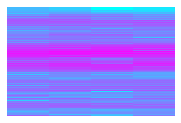

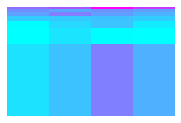

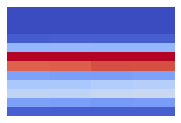

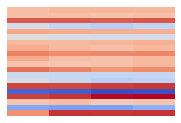

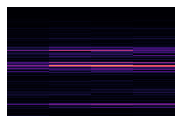

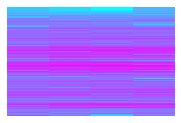

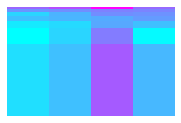

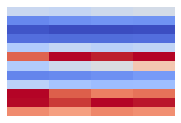

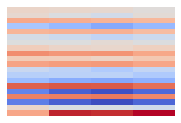

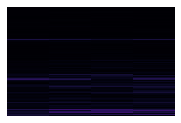

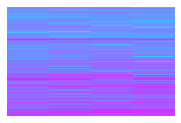

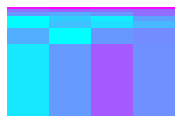

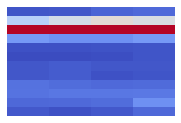

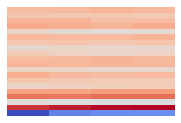

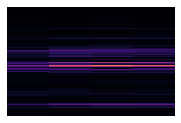

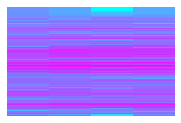

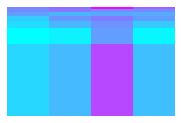

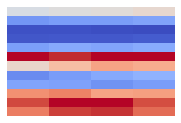

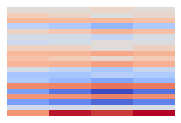

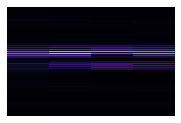

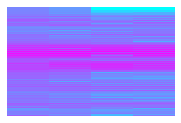

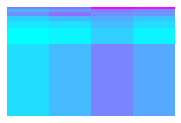

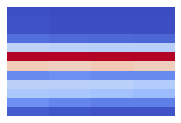

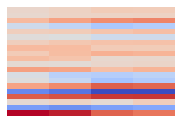

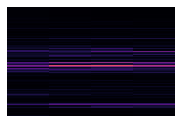

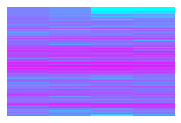

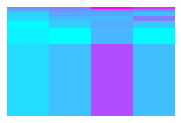

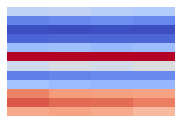

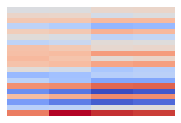

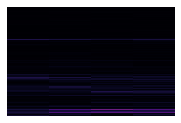

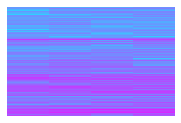

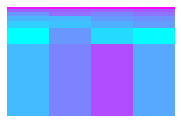

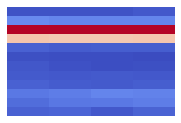

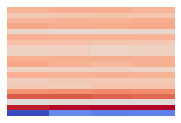

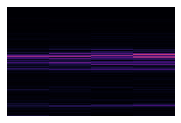

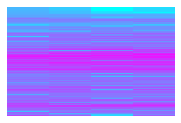

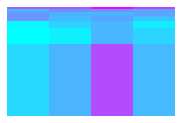

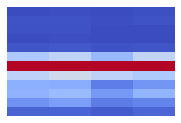

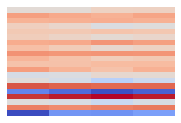

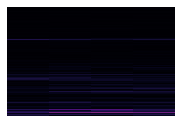

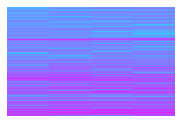

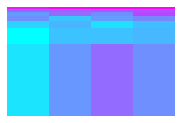

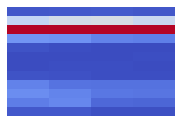

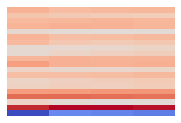

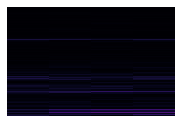

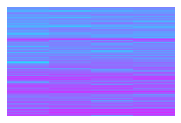

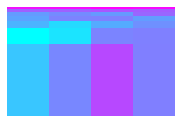

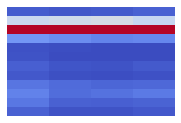

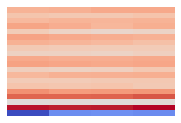

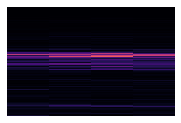

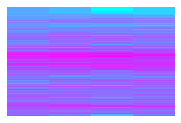

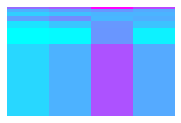

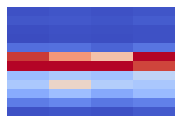

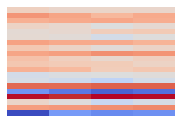

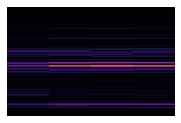

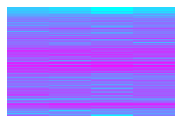

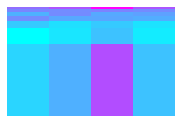

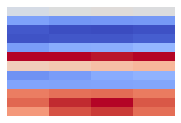

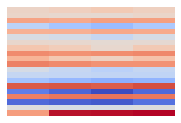

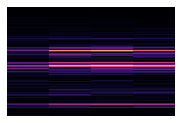

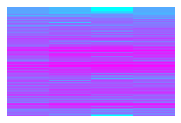

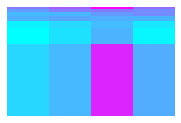

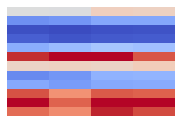

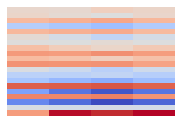

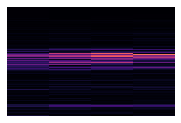

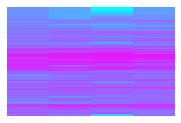

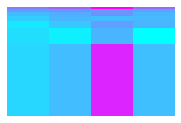

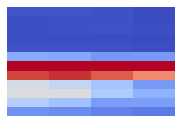

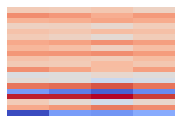

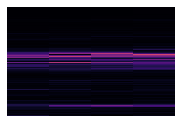

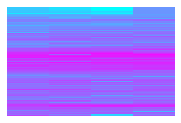

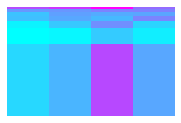

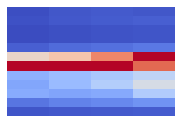

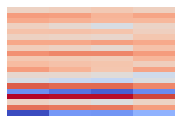

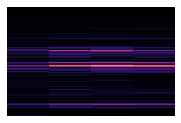

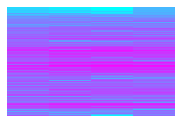

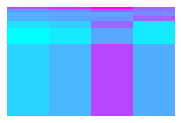

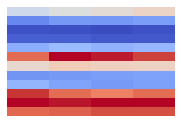

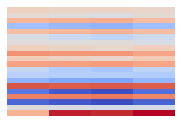

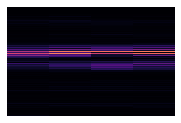

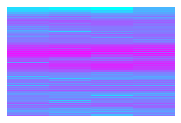

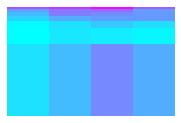

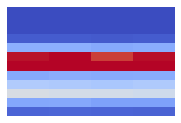

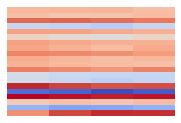

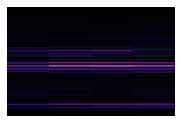

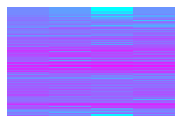

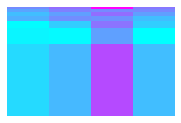

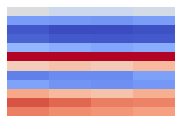

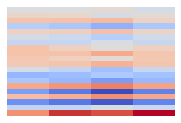

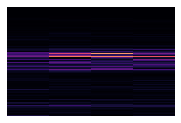

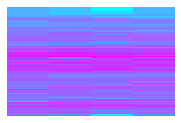

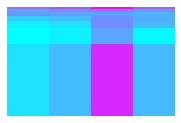

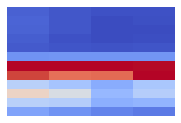

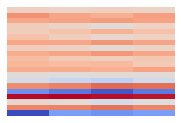

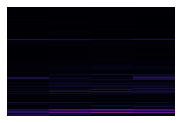

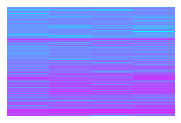

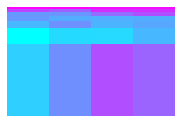

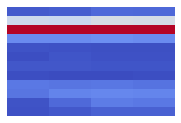

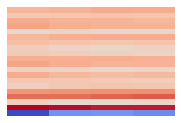

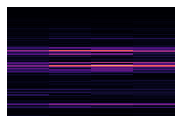

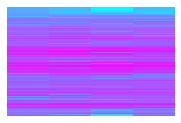

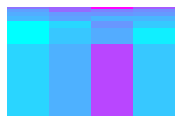

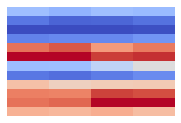

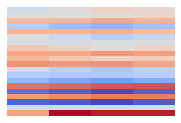

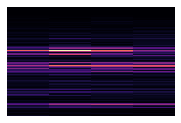

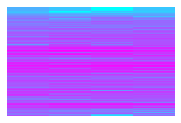

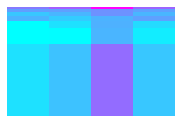

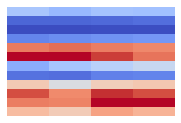

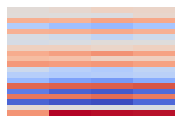

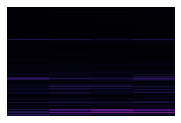

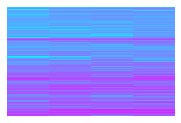

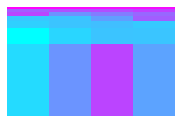

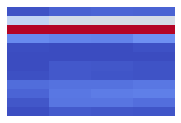

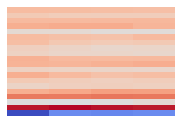

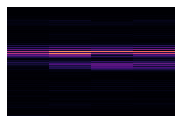

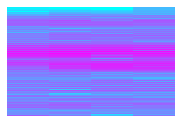

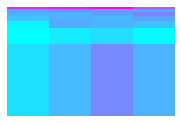

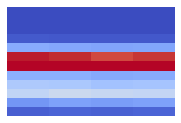

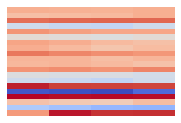

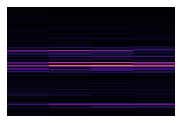

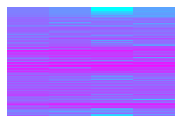

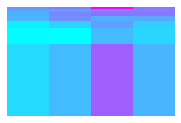

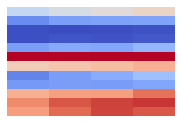

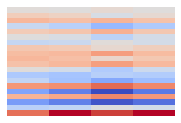

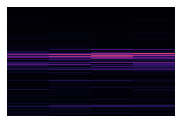

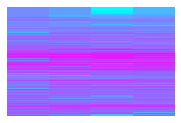

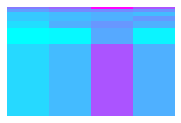

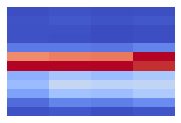

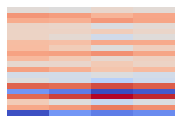

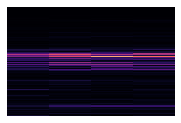

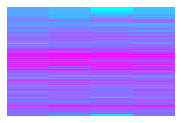

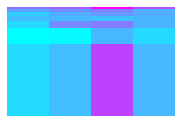

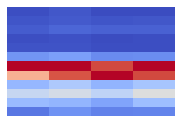

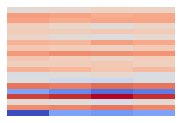

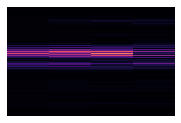

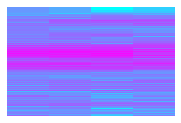

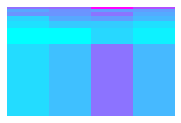

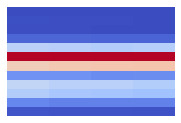

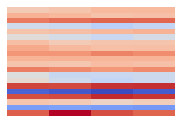

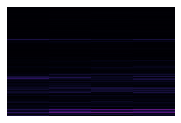

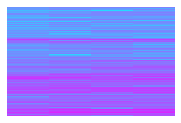

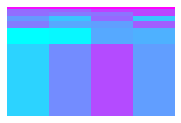

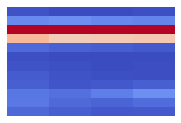

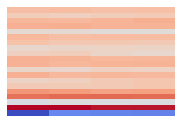

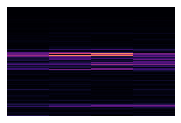

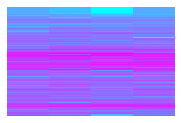

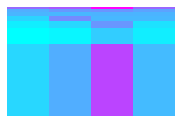

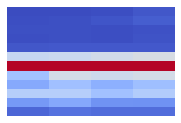

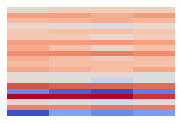

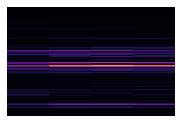

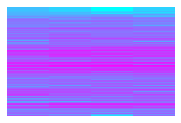

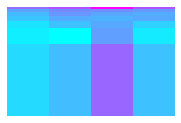

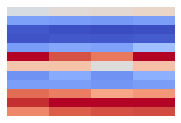

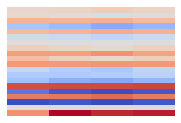

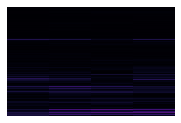

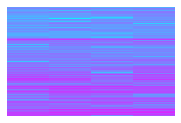

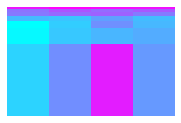

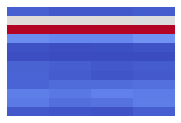

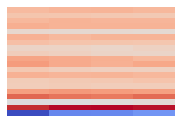

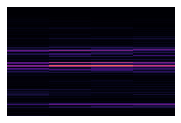

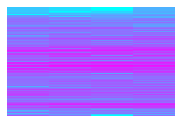

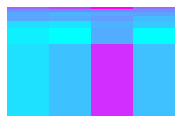

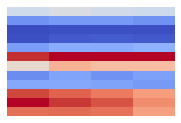

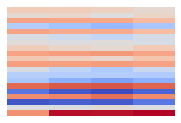

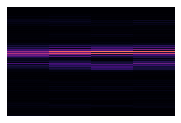

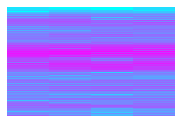

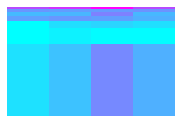

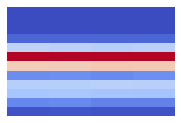

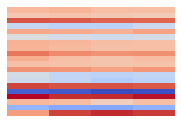

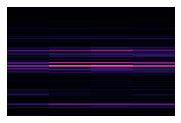

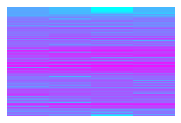

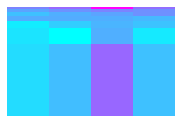

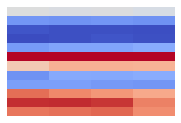

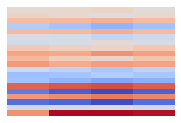

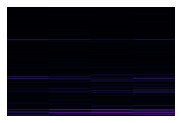

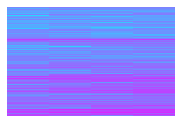

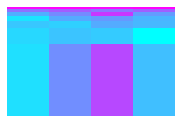

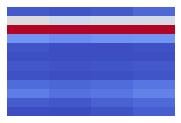

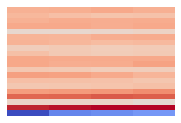

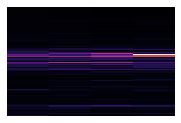

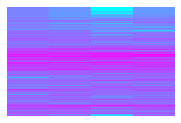

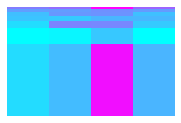

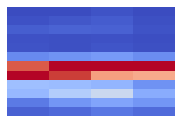

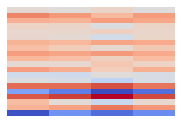

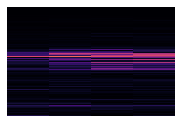

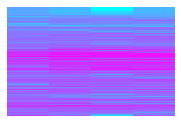

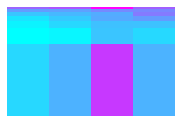

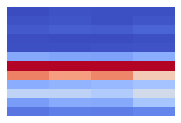

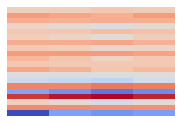

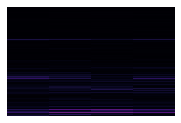

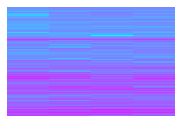

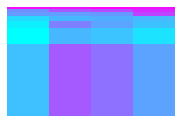

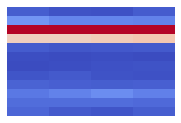

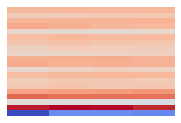

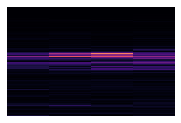

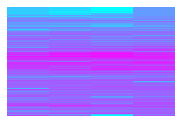

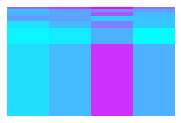

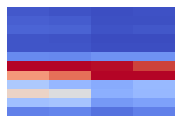

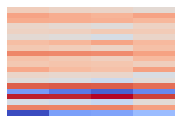

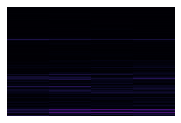

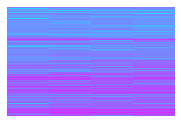

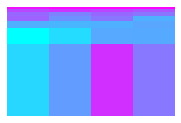

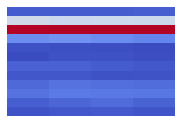

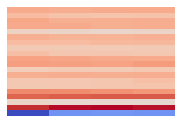

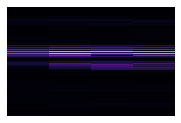

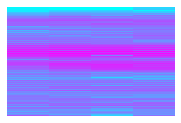

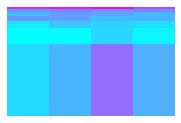

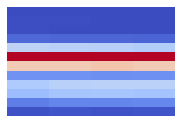

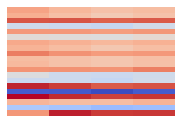

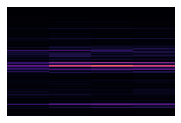

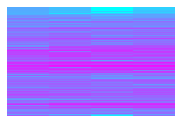

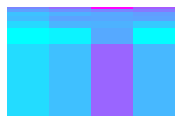

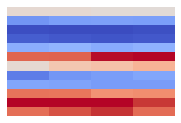

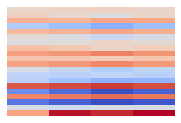

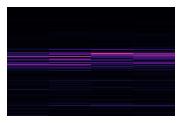

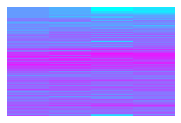

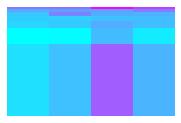

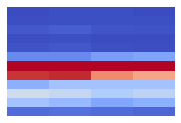

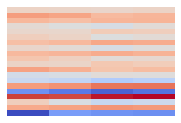

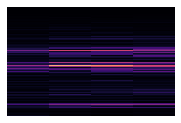

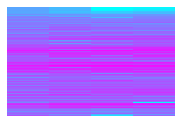

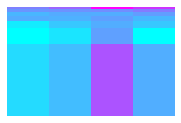

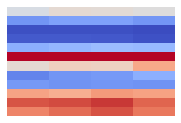

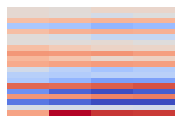

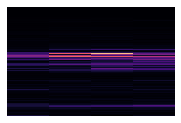

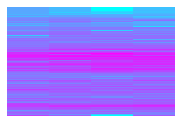

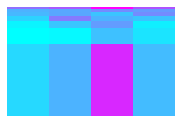

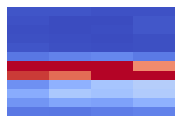

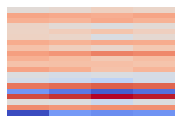

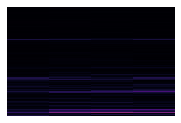

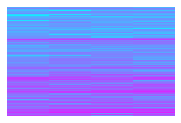

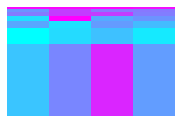

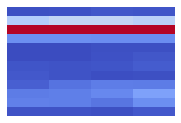

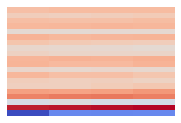

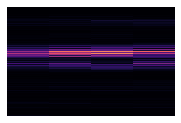

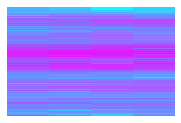

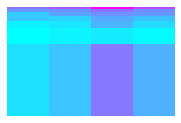

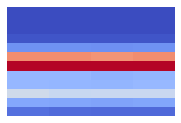

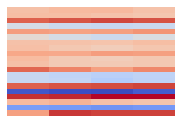

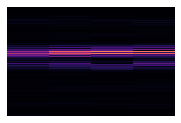

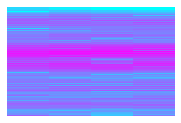

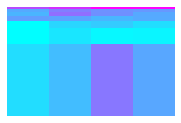

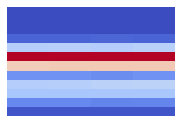

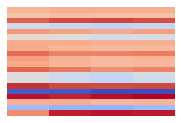

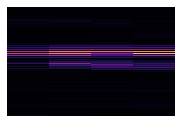

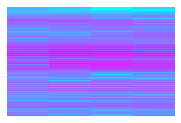

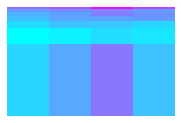

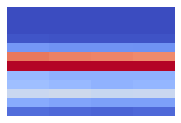

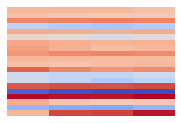

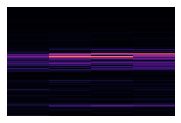

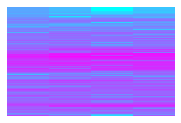

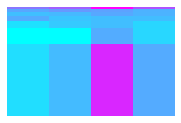

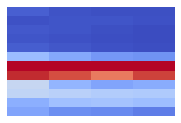

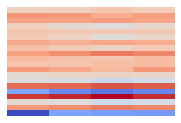

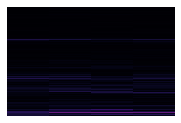

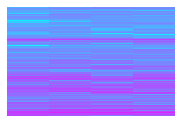

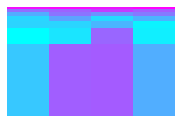

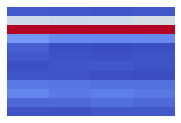

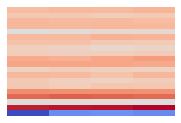

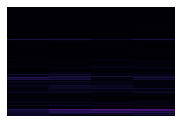

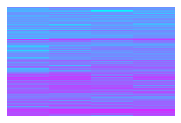

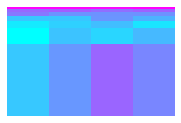

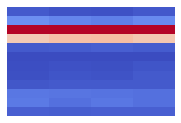

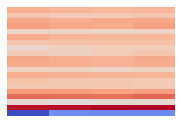

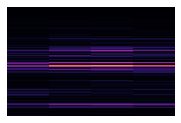

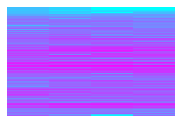

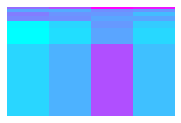

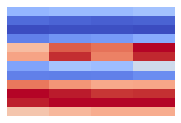

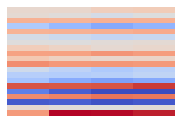

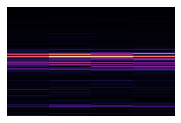

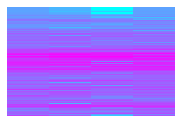

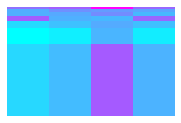

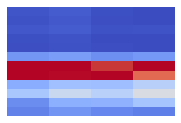

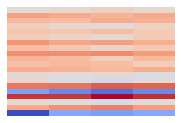

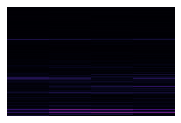

In [ ]:
mels_train, mels_test = processing_images(audios_train,audios_test);

In the end, we get different a 5-graphs picture for every sound that we will use in the CNN to predict the defect.

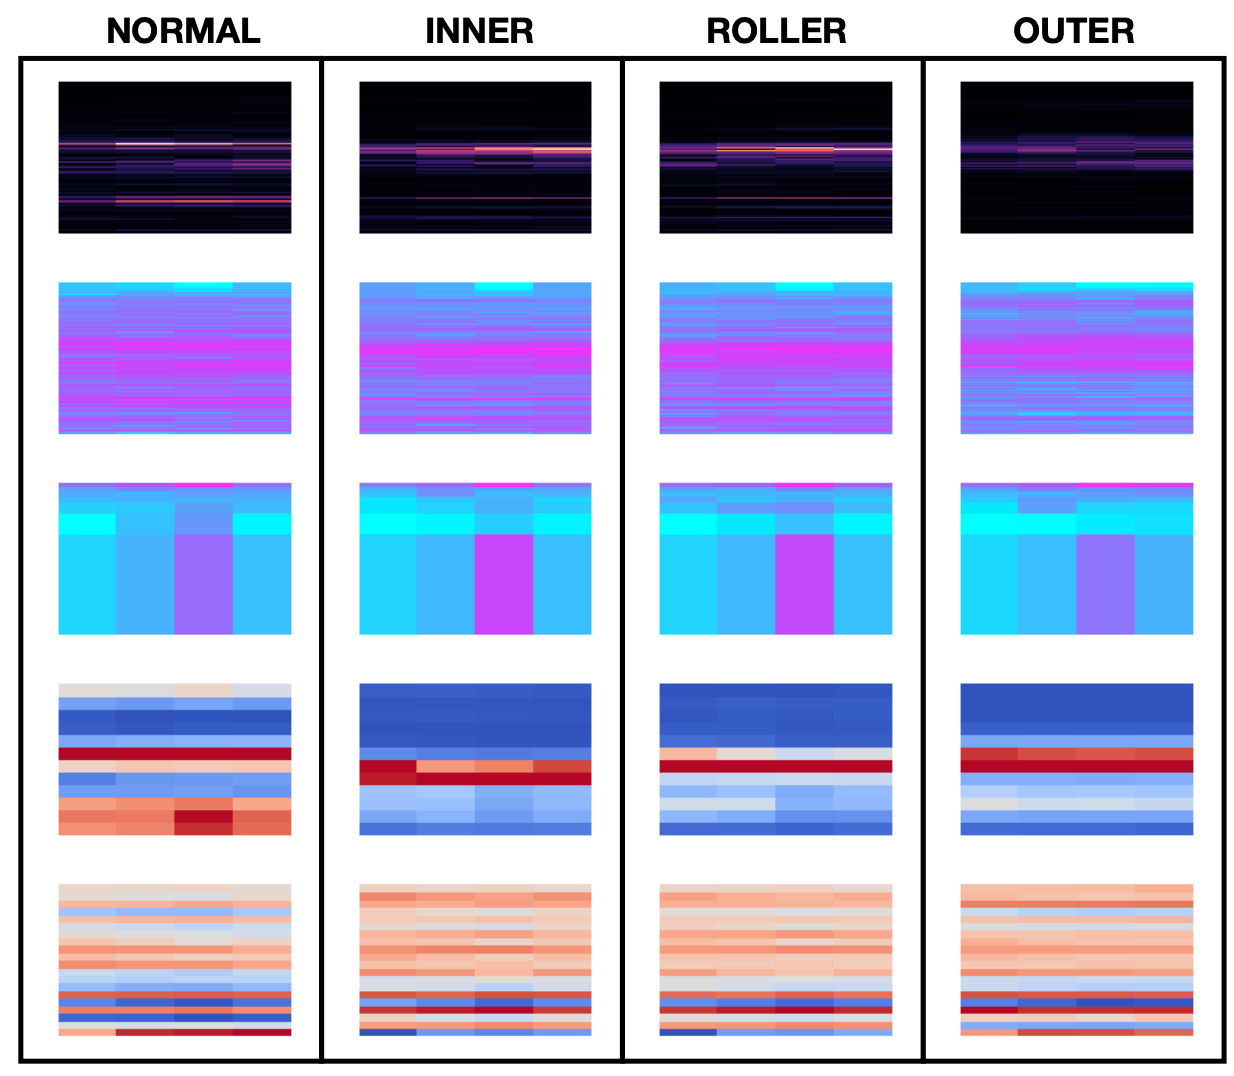

Now we define the CNN model.

In [ ]:
def CNNModel(input_shape,classes=4):
    X_input = Input(input_shape)
    
    X = Conv2D(4,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Flatten()(X)

    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='GenreModel')

    return model

Now we can binarize the different labels to have the good inputs for the model.

In [ ]:
lb = preprocessing.LabelBinarizer()
y_training = lb.fit_transform(label_train)

In [ ]:
def get_precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  
model = CNNModel(input_shape=(720, 216, 3),classes=4)
opt = Adam(learning_rate=0.005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=["accuracy",get_f1]) 
history = model.fit(x=np.asarray(mels_train), y=np.asarray(y_training),epochs=30, validation_split=0.2,shuffle=True,batch_size=len(mels_train),verbose=1)

In [ ]:
fig = plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


plt.subplot(2, 2, 2)
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_cnn = model.predict_generator(np.asarray(mels_test))
y_cnn = np.argmax(y_cnn,axis=1).tolist()

In [ ]:
print("Accuracy: ",accuracy_score(label_test,y_cnn))
print("Precision: ",precision_score(label_test,y_cnn,average='macro'))
print("Recall: ",recall_score(label_test,y_cnn,average='macro'))
print("F1 score: ",f1_score(label_test,y_cnn,average='macro'))

cm = confusion_matrix(label_test, y_cnn)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Inner','Roller','Outer'])

fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(title='Sklearn Confusion Matrix', xlabel='Predicted', ylabel='Actual')
plt.show()

> üìå This method seems to give poor results, the model tend to have difficulties to understand the patterns.

---

# <p style="background-color:#C2586E;color:white;font-size:100%;text-align:center;border-radius:10px 10px;">4. Features extraction approach</p>

To extract informations from the data, we will use the different graph representations to get interesting features.

In [ ]:
def feature_extract(row):
    ls_mean = []
    ls_var =[]
    pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    
    try:
        y = np.array(row)
        sr = frequence
        
        length = len(y)/sr
        
        mean_stft = np.mean(librosa.feature.chroma_stft(y=y,sr=sr))
        var_stft = np.var(librosa.feature.chroma_stft(y=y,sr=sr))
        tempo = librosa.beat.tempo(y,sr=sr)[0]
        
        S,phase = librosa.magphase(librosa.stft(y))
        rms = librosa.feature.rms(S=S)
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        
        centroid = librosa.feature.spectral_centroid(S=S)
        centroid_mean = np.mean(centroid)
        centroid_var = np.var(centroid)
        
        bandwidth = librosa.feature.spectral_bandwidth(S=S)
        bandwidth_mean = np.mean(bandwidth)
        bandwidth_var = np.var(bandwidth)
        
        rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr,roll_percent=0.85)
        rolloff_mean = np.mean(rolloff)
        rolloff_var = np.var(rolloff)
        
        zerocrossing = librosa.feature.zero_crossing_rate(y=y)
        crossing_mean = np.mean(zerocrossing)
        crossing_var = np.var(zerocrossing)
        
        y_harmonic = librosa.effects.harmonic(y=y)
        harmonic_mean = np.mean(y_harmonic)
        harmonic_var = np.var(y_harmonic)
        
        contrast = librosa.feature.spectral_contrast(S=S,sr=sr,fmin=5)
        contrast_mean = np.mean(contrast)
        contrast_var = np.var(contrast)
        mfcc= librosa.feature.mfcc(y=y,sr=sr)
        for i in range(0,20):
            ls_mean.append(np.mean(mfcc[i]))
            ls_var.append(np.var(mfcc[i]))
            
        key = librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1).argmax()
        key_name = pitches[librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1).argmax()]
        
        if librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1)[(key+3)%12] > librosa.feature.chroma_stft(y=y,sr=sr).sum(axis=1)[(key+4)%12]:
             scale = 'minor'
        else:
             scale = 'Major'
        
    except Exception as e: 
        print(e)
        length = 0
        mean_stft =0
        var_stft = 0
        tempo=0
        rms_mean =0 
        rms_var= 0
        centroid_mean=0
        centroid_var=0
        bandwidth_mean =0
        bandwidth_var=0
        rolloff_mean = 0
        rolloff_var = 0
        crossing_mean = 0
        crossing_var = 0
        harmonic_mean=0
        harmonic_var =0
        contrast_mean = 0
        contrast_var =0
        key = 0
        key_name=0
        scale =0
        
        for i in range(0,20):
            ls_mean.append(0) 
            ls_var.append(0)
        
    return [length,mean_stft,var_stft,tempo,rms_mean,rms_var,centroid_mean,centroid_var,\
bandwidth_mean,bandwidth_var,rolloff_mean,rolloff_var, crossing_mean,crossing_var,\
harmonic_mean,harmonic_var,contrast_mean,contrast_var,key,key_name,scale,ls_mean[0],ls_var[0],ls_mean[1],ls_var[1],ls_mean[2],ls_var[2],\
ls_mean[3],ls_var[3],ls_mean[4],ls_var[4],ls_mean[5],ls_var[5],ls_mean[6],ls_var[6],ls_mean[7],ls_var[7],ls_mean[8],ls_var[8],\
ls_mean[9],ls_var[9],ls_mean[10],ls_var[10],ls_mean[11],ls_var[11],ls_mean[12],ls_var[12],ls_mean[13],ls_var[13],ls_mean[14],ls_var[14],\
ls_mean[15],ls_var[15],ls_mean[16],ls_var[16],ls_mean[17],ls_var[17],ls_mean[18],ls_var[18],ls_mean[19],ls_var[19]]

In [ ]:
columns=['length','mean_stft','var_stft','tempo','rms_mean','rms_var','centroid_mean','centroid_var',\
'bandwidth_mean','bandwidth_var','rolloff_mean','rolloff_var', 'crossing_mean','crossing_var',\
'harmonic_mean','harmonic_var','contrast_mean','contrast_var','key','key_name','scale','mfcc1_mean','mfcc1_var','mfcc2_mean','mfcc2_var','mfcc3_mean','mfcc3_var','mfcc4_mean','mfcc4_var',\
        'mfcc5_mean','mfcc5_var','mfcc6_mean','mfcc6_var','mfcc7_mean','mfcc7_var','mfcc8_mean','mfcc8_var',\
        'mfcc9_mean','mfcc9_var','mfcc10_mean','mfcc10_var','mfcc11_mean','mfcc11_var','mfcc12_mean','mfcc12_var',\
        'mfcc13_mean','mfcc13_var','mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var','mfcc16_mean','mfcc16_var',\
        'mfcc17_mean','mfcc17_var','mfcc18_mean','mfcc18_var','mfcc19_mean','mfcc19_var','mfcc20_mean','mfcc20_var']

In [ ]:
df_train = pd.DataFrame()
for audio in audios_train:
    df_new = pd.DataFrame(feature_extract(audio)).T
    df_train = pd.concat([df_train,df_new])
    
df_train.reset_index(drop=True,inplace=True)
df_train.columns = columns

df_test = pd.DataFrame()
for audio in audios_test:
    df_new = pd.DataFrame(feature_extract(audio)).T
    df_test = pd.concat([df_test,df_new])
    
df_test.reset_index(drop=True,inplace=True)
df_test.columns = columns

In [ ]:
df_train

In [ ]:
corr_df = pd.concat([df_train,pd.DataFrame(label_train)],axis=1)
corr_df = corr_df.rename(columns={0: "type"})

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in corr_df.columns if ('mean' in col or 'type' in col)]
corr = corr_df[spike_cols].astype(float).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler

features = ['length','mean_stft','var_stft','tempo','rms_mean','rms_var','centroid_mean','centroid_var',\
'bandwidth_mean','bandwidth_var','rolloff_mean','rolloff_var', 'crossing_mean','crossing_var',\
'harmonic_mean','harmonic_var','contrast_mean','contrast_var','mfcc1_mean','mfcc1_var','mfcc2_mean','mfcc2_var','mfcc3_mean','mfcc3_var','mfcc4_mean','mfcc4_var',\
        'mfcc5_mean','mfcc5_var','mfcc6_mean','mfcc6_var','mfcc7_mean','mfcc7_var','mfcc8_mean','mfcc8_var',\
        'mfcc9_mean','mfcc9_var','mfcc10_mean','mfcc10_var','mfcc11_mean','mfcc11_var','mfcc12_mean','mfcc12_var',\
        'mfcc13_mean','mfcc13_var','mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var','mfcc16_mean','mfcc16_var',\
        'mfcc17_mean','mfcc17_var','mfcc18_mean','mfcc18_var','mfcc19_mean','mfcc19_var','mfcc20_mean','mfcc20_var']

pca = PCA()
SS = StandardScaler()
scaled_data = SS.fit_transform(df_train[features])
components = pd.DataFrame(pca.fit_transform(scaled_data))
plt.figure(figsize=(15,6)).suptitle('Principal Component Analysis', fontsize=16)
fig = sns.scatterplot(x=components[0], y=components[1], hue=label_train)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Explained variance" : pca.explained_variance_,
        "% explained variance" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. explained variance" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

In [ ]:
eig.plot.bar(x = "Dimension", y = "% explained variance",figsize=(15,10),title="Explained variation of differents dimensions") # permet un diagramme en barres
plt.show()

Visually here we will stop at 6 dimensions.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)
mean_pca = cross_val_score(clf, components.iloc[: , :5], label_train, cv=5).mean()
mean_all = cross_val_score(clf, df_train[features].loc[:, df_train[features].columns!="type"], label_train, cv=5).mean()

pd.DataFrame({"Average precision with PCA" : [mean_pca], 
              "Average precision without PCA" : [mean_all], 
              "Number of components" : [components.shape[1]]})

We have a 98% average precision with only 5 predictors using the PCA, compared to 58. We will use this method to avoid overfitting since we don't have much data.

In [ ]:
x_train = pd.DataFrame(pca.fit_transform(SS.fit_transform(df_train[features]))).iloc[: , :5]
x_test = pd.DataFrame(pca.transform(SS.transform(df_test[features]))).iloc[: , :5]

In [ ]:
clf.fit(x_train,label_train)
y_pred = clf.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay

print("Accuracy: ",accuracy_score(label_test,y_pred))
print("Precision: ",precision_score(label_test,y_pred,average='macro'))
print("Recall: ",recall_score(label_test,y_pred,average='macro'))
print("F1 score: ",f1_score(label_test,y_pred,average='macro'))

cm = confusion_matrix(label_test, y_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Inner','Roller','Outer'])

fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(title='Sklearn Confusion Matrix', xlabel='Predicted Churn', ylabel='Actual Churn')
plt.show()

> üìå This method seems to give really good results since we almost have a perfect score for the test dataset.

---

# <p style="background-color:#C2586E;color:white;font-size:100%;text-align:center;border-radius:10px 10px;">5. Using both techniques combined</p>

Here I will combine both techniques to study the results.

In [ ]:
from keras.layers import (Conv1D, MaxPool1D, Dropout, Flatten, Dense,Input, concatenate)
from keras.models import Model, Sequential

def CombineModel(input_shape,sequence_shape,classes=4):
    features = Input(sequence_shape)
    X_input = Input(input_shape)
    
    X = Conv2D(4,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    part1 = Flatten()(X)
    
    merged = concatenate([part1, features])
    
    final = Dense(256, activation='relu')(merged)
    final = Dropout(0.3, seed=789)(final)
    final = Dense(4, activation='softmax')(final)

    model = Model(inputs=[X_input, features], outputs=[final])

    return model

In [ ]:
model = CombineModel(input_shape=(720, 216, 3),sequence_shape=(5,),classes=4)
opt = Adam(learning_rate=0.005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=["accuracy"]) 
history = model.fit(x=[np.asarray(mels_train),x_train], y=np.asarray(y_training),epochs=30, validation_split=0.2,shuffle=True,batch_size=len(mels_train),verbose=1)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_cnn = model.predict_generator([np.asarray(mels_test),x_test])
y_cnn = np.argmax(y_cnn,axis=1).tolist()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy: ",accuracy_score(label_test,y_cnn))
print("Precision: ",precision_score(label_test,y_cnn,average='macro'))
print("Recall: ",recall_score(label_test,y_cnn,average='macro'))
print("F1 score: ",f1_score(label_test,y_cnn,average='macro'))

cm = confusion_matrix(label_test, y_cnn)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Inner','Roller','Outer'])

fig, ax = plt.subplots(figsize=(10,10))
cmd_obj.plot(ax=ax)

cmd_obj.ax_.set(title='Sklearn Confusion Matrix', xlabel='Predicted', ylabel='Actual')
plt.show()

> üìå This method seems to give poor results, the model tend to have difficulties to understand the patterns.

---
# <p style="background-color:#89394A;color:white;font-size:100%;text-align:center;border-radius:10px 10px;">Take away points</p>

>**1.** We can perform preprocessing on the records to have insights: especially visuals and different graphs to give informations on the amplitudes and frequency present in the sounds.
>
>**2.** The best model seems to be the feature extraction method that give a 100% accurate prediction.
>
>**3.** It is obvious that the number of data is very low to construct a very accurate model for new data. This work only use available data that have been giver for the study by the University of Ottawa.